# data_processing_baseline

## make canonsmiles

In [ ]:
from tqdm import tqdm
import json
from rdkit import Chem
filename = '/share/data3/yuxiao/testt/mols.json'
with open(filename,'r') as f:
    results = json.load(f)
import json
for result in tqdm(results):
    try:
        canon = Chem.CanonSmiles(result['smiles'])
    except:
        continue
    if canon != result['smiles']:
        result['smiles'] = canon
        print(1)
filename = '/share/data3/yuxiao/testt/mols.json'
with open(filename,'w') as f:
    json.dump(results,f)

## make tokenizer

In [ ]:
filename = '/share/data3/yuxiao/testt/mols.json'
with open(filename,'r') as f:
    results = json.load(f)
with open('training.smi','a') as f:   
    for result in results:
        f.write(result['smiles']+"\n")
    

In [ ]:
!python Image2Smiles/train_tokenizer.py  --training_files ./ --do_train --do_test \
--tokenizer_name tokenizer_vocab_100.json \
--vocab_size 100 --min_frequency 2

In [ ]:
with open('Image2Smiles/tokenizers/tokenizer_vocab_100.json','r') as f:
    data = json.load(f)
keys= list(data['model']['vocab'].keys())
for key in keys[::-1]:
    if len(key)>6:
        keys.remove(key)
keys = sorted(keys,key = lambda i:len(i),reverse = True)
string = '|'.join(keys)
print(string)

In [ ]:
import re
string = 'abc]('
pattern = r'(ccccc|CCCCC|CCCC|cccc|CCCN|ccc|CCC|CCN|COc|\)\(=|OCC|CCc|ncc|cnc|-\]\)|COC|@@\]|cc|CC|\(=|\]\(|@@|NC|\)\[|nc|Cc|OC|CO|Cl|\(-|\)\(|Nc|CN|nH|\)=|12|Oc|cn|-\]|nn|\+\]|\(\[|@\]|21|Br|oc|#|%|\(|\)|\+|-|\.|/|0|1|2|3|4|5|6|7|8|9|=|@|A|B|C|F|H|I|K|L|M|N|O|P|R|S|T|X|Z|\[|\|\]|a|b|c|e|g|i|l|n|o|p|r|s|t|Ċ)'
tokens = list(filter(None,re.split(pattern,string)))
raw = ' '.join(tokens)

## create split dataset

In [ ]:
import json
import re
pattern = r'(ccccc|CCCCC|CCCC|cccc|CCCN|ccc|CCC|CCN|COc|\)\(=|OCC|CCc|ncc|cnc|-\]\)|COC|@@\]|cc|CC|\(=|\]\(|@@|NC|\)\[|nc|Cc|OC|CO|Cl|\(-|\)\(|Nc|CN|nH|\)=|12|Oc|cn|-\]|nn|\+\]|\(\[|@\]|21|Br|oc|#|%|\(|\)|\+|-|\.|/|0|1|2|3|4|5|6|7|8|9|=|@|A|B|C|F|H|I|K|L|M|N|O|P|R|S|T|X|Z|\[|\|\]|a|b|c|e|g|i|l|n|o|p|r|s|t|Ċ)'
from tqdm import tqdm
filename = '/share/data3/yuxiao/testt/mols.json'
with open(filename,'r') as f:
    result = json.load(f)
dic = {}
li = []
num = 0
for i in tqdm(range(len(result))):
#     if len(result[i]['smiles']) > 50:
#         continue
    item = {}
    item['sentids'] = [num]
    item['imgid'] = num
    di = {}
#     di['tokens'] = list(result[i]['smiles'])
    di['tokens'] = list(filter(None,re.split(pattern,result[i]['smiles'])))
    if len(di['tokens']) > 100:
        continue
    di['raw'] = ' '.join(result[i]['smiles'])
    di['raw'] =  ' '.join(di['tokens'])
    di['imgid'] = num
    di['sentid'] = num
    sentence = [di]
    item['sentences'] = sentence
    if i < 0.8*len(result):
        item['split'] = 'train'
    elif i < 0.9*len(result):
        item['split'] = 'val'
    else:
        item['split'] = 'test'
#     item['filename'] = str(num)+'.png'
    item['filename'] = result[i]['image'].split('/')[-1]
    num += 1
    li.append(item)
dic['images'] = li
dic['dataset'] = 'all'
filename = '/share/data3/yuxiao/testt/ImageCaptioning.pytorch/data/all.json'
with open(filename,'w') as f:
    json.dump(dic,f)

In [1]:
import json
filename = '/share/data3/yuxiao/testt/ImageCaptioning.pytorch/data/all.json'
with open(filename,'r') as f:
    result = json.load(f)
len(result['images'])

1884899

# Training baseline

## word stastistic

In [8]:
!python scripts/prepro_labels.py --input_json data/all.json \
--output_json data/alltalk.json --output_h5 data/alltalk \
--max_length 100

Traceback (most recent call last):
  File "scripts/prepro_labels.py", line 39, in <module>
    import skimage.io
ModuleNotFoundError: No module named 'skimage'


## extract_features(Resnet101,as npz,using multi-gpu)

In [ ]:
!python scripts/prepro_feats.py --input_json data/all.json \
--output_dir data/all --images_root /share/data3/yuxiao/testt/mols




parsed input parameters:
{
  "input_json": "data/all.json",
  "output_dir": "data/all",
  "images_root": "/share/data3/yuxiao/testt/mols",
  "att_size": 14,
  "model": "resnet101",
  "model_root": "./data/imagenet_weights"
}


## train(transformorer)

In [ ]:
!python tools/train.py --id fc1  --input_json data/alltalk.json \
--caption_model transformer \
--input_att_dir data/all_att \
--input_label_h5 data/alltalk_label.h5 \
--batch_size 64 --learning_rate 5e-4 --learning_rate_decay_start 0 --scheduled_sampling_start 0 \
--checkpoint_path log_fc1 --save_checkpoint_every 10000 --val_images_use 10000 --max_epochs 15 \
--start_from log_fc --id fc-best



ssh -L 16006:127.0.0.1:6006 username@remote_server_ip

In [ ]:
!tensorboard --logdir='./log_fc1'

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6007/ (Press CTRL+C to quit)


## train(self-critical,reinforcement learning) 

In [42]:
!python scripts/prepro_ngrams.py --input_json data/splitshortmols.json --dict_json data/splitshortmolstalk.json \
--output_pkl data/mols-train --split train

total imgs: 888812
count_refs: 888812


In [43]:
!bash scripts/copy_model.sh fc fc_rl

In [2]:
!python tools/train.py --id fc_rl  --input_json data/splitshortmolstalk.json \
--caption_model transformer \
--input_att_dir data/shortfmolstalk_att \
--input_label_h5 data/splitshortmolstalk_label.h5  --start_from log_fc_rl \
--batch_size 32 --learning_rate 5e-5 --learning_rate_decay_start 0 --scheduled_sampling_start 0 \
--checkpoint_path log_fc_rl --save_checkpoint_every 20000 --val_images_use 80000 --max_epochs 20  \
--language_eval 0 --self_critical_after 0 --cached_tokens mols-train-idxs --train_sample_n 5



# evaluate baseline

## evaluate with raw images

In [7]:
import cv2
for i in range(300):
    filename = '/share/data3/yuxiao/testt/mols/'+str(i)+'.png'
    img =cv2.imread(filename)
    filename = 'blah/'+str(i)+'.png'
    cv2.imwrite(filename,img)

In [13]:
!python tools/eval.py --model log_fc/model-best.pth --infos_path log_fc/infos_fc-best.pkl \
--image_folder blah --num_images -1 --force 1 --device cuda  --batch_size 16


Hugginface transformers not installed; please visit https://github.com/huggingface/transformers
meshed-memory-transformer not installed; please run `pip install git+https://github.com/ruotianluo/meshed-memory-transformer.git`
DataLoaderRaw loading images from folder:  blah
0
listing all images in directory blah
DataLoaderRaw found  300  images
cp "blah/110.png" vis/imgs/img1.jpg
image 1: CN ( C ) CCN C (= O ) NC CN C (= O ) N 1 CCN ( c 2 ccccc 2 ) CC 1
cp "blah/74.png" vis/imgs/img2.jpg
image 2: CCCC NC (= O )[ C @ H ]( Cc 1 ccc ( O ) cc 1 ) NC (= O )[ C H ]( CC ( C ) C ) NC (= O ) c 1 ccccc 1 CN C 1 = O
cp "blah/82.png" vis/imgs/img3.jpg
image 3: CCC ( CC ) CN c 1 nc ( C # N ) nc 2 c 1 nc n 2 Cc 1 ccccc 1
cp "blah/91.png" vis/imgs/img4.jpg
image 4: N = C ( N ) NC (= O ) N NC (= O ) N [ C @ H ] 1 c 1 cccc ( OC 2 CCN ( CC 3 ( Oc 4 ccc nc 4 ) CC 3 ) c 12
cp "blah/253.png" vis/imgs/img5.jpg
image 5: Cc 1 n oc (- c 2 ccc s 2 ) c 1 C (= O ) O
cp "blah/112.png" vis/imgs/img6.jpg
image 6: Cc 

image 58: CC ( C )= CCC / C ( C )= C / C (= O ) C 1 = C ( O ) C (= O ) C 2 = C ( O ) C (= O ) c 3 c ( O ) cc ( O ) c 3
cp "blah/121.png" vis/imgs/img59.jpg
image 59: COc 1 cc 2 c ( c ( OC ) cc 1 - c 1 cc 3 c ( cc 1 OC ) OC O [ C @ H ] 1 O [ C @ H ]( CO [ C H ] 2 O [ C @ H ](
cp "blah/192.png" vis/imgs/img60.jpg
image 60: CC ( C ) C [ C @ H ]( NC (= O )[ C @ H ]( CC ( C ) C ) NC (= O )[ C @ H ]( CC ( C ) C ) NC (= O )[ C @ H ]( CC ( C )
cp "blah/168.png" vis/imgs/img61.jpg
image 61: CCN ( CC ) C (= O ) N 1 CCN ( C (= O ) c 2 cc ( OC ) c ( OC ) c ( OC ) c 2 ) C 2 CN ( C (= O ) OC ) c 2 cc ( OC ) c
cp "blah/4.png" vis/imgs/img62.jpg
image 62: Br c 1 ccccc 1 Nc 1 nc ( N 2 CC OCC 2 ) nc 2 cnc cc 12
cp "blah/172.png" vis/imgs/img63.jpg
image 63: c 1 ccc 2 c ( c 1 ) OCC O 2 ) N 1 CCN ( c 2 cccc 3 [ nH ] ncc 2 3 ) CC 1
cp "blah/106.png" vis/imgs/img64.jpg
image 64: NC (= O )[ C @ H ]( Cc 1 ccccc 1 ) NC (= O )[ C @ H ]( Cc 1 ccccc 1 ) NC (= O )[ C @ H ]( CCCN = C ( N ) N ) NC (= O )[ C @ H ](
e

cp "blah/262.png" vis/imgs/img113.jpg
image 113: CC O P (= O )( OCC ) Oc 1 ccc ( S (= O )(= O ) C [ C @ H ] 2 [ C H ] 3 CC [ C H ] 4 [ C H ]( C )[ C H ] 5
cp "blah/15.png" vis/imgs/img114.jpg
image 114: CCCCC CCCCC / C = C \ C [ C H ] 1 [ C H ]( O [ C @ H ] 2 [ C H ] 3 [ C H ]( O [ C @ H ] 4 [ C H ]( O
cp "blah/222.png" vis/imgs/img115.jpg
image 115: CC (= O ) O [ C H ] 1 [ C @ H ]( OC / C = C / c 2 ccccc 2 ) C [ C H ] 2 [ C H ] 3 [ C H ]( C [ C H
cp "blah/189.png" vis/imgs/img116.jpg
image 116: OC ( / C = C / C = C / C = C / c 1 ccccc 1 ) C ( O ) CCc 1 ccccc 1
cp "blah/128.png" vis/imgs/img117.jpg
image 117: CC OC (= O ) c 1 cnc 2 ccc ( NC (= O ) OCC ) cc 2 c 1 Nc 1 cccc ( NC (= O ) OCC ) c 1
cp "blah/85.png" vis/imgs/img118.jpg
image 118: CCCCC C [ C @ H ] 1 C (= O ) O [ C H ]( Cc 2 ccccc 2 ) NC (= O )[ C H ]( C ) O [ C H ] 2 [ C @ H ]( C ) NC (= O
cp "blah/295.png" vis/imgs/img119.jpg
image 119: CC ( C )( C ) NC (= O )[ C @ H ]( Cc 1 ccc ( O ) cc 1 ) NC (= O )[ C @ H ]( Cc 1 ccc ( O

image 176: COc 1 cc 2 c (= O ) cc 3 c ( c ( OC ) c 1 OC ) C (= O ) NC ( C )= C / C = C \ C = C \ C = C \ C = C \ C = C \
evaluating validation preformance... 176/300 (0.000000)
cp "blah/285.png" vis/imgs/img177.jpg
image 177: CC OC (= O ) COC (= O ) N 1 CCCC 1 C (= O ) N 1 CCCC 1 c 1 ccc ( C ( F )( F ) F ) nn 1 - c 1 ccc ( S ( N )(= O )= O ) cc 1
cp "blah/287.png" vis/imgs/img178.jpg
image 178: C [ C @ H ] 1 O [ C @ H ]( O [ C @ H ] 2 O [ C @ H ]( CO [ C H ] 3 O [ C @ H ]( CO [ C H ] 4 O [ C @
cp "blah/178.png" vis/imgs/img179.jpg
image 179: CC 1 ( C ) C [ C @ H ]( NC (= O ) c 2 ccc ( NC (= O ) c 3 cc ( Cl ) cc ( Cl ) c 3 Cl ) C (= O ) N [ C H ]( CC (= O
cp "blah/99.png" vis/imgs/img180.jpg
image 180: N = C ( N ) C (= O ) N [ C H ]( C (= O ) N [ C H ]( N ) C (= O ) N [ C H ]( N ) C (= O ) N [ C H ](
cp "blah/27.png" vis/imgs/img181.jpg
image 181: COc 1 cc ( / C = C / C (= O ) c 2 cc ( OC ( C )= O ) c ( OC (= O ) / C = C / c 3 ccc ( O ) cc 3 ) c ( OC (= O ) /
cp "blah/186.png" vis/imgs/

image 237: CCN ( CC ) CCN C (= O )[ C @ H ]( Cc 1 ccc ( C (= O ) N [ C H ]( Cc 2 ccc 3 ccccc 3 c 2 ) C (= O ) N [ C H ]( Cc 2 ccc (
cp "blah/281.png" vis/imgs/img238.jpg
image 238: CN ( C ) C (= O ) N [ C H ]( Cc 1 ccc ( O ) cc 1 ) C (= O ) N [ C H ]( Cc 1 ccc ( O ) cc 1 ) C (= O ) NC c 1 ccccc
cp "blah/288.png" vis/imgs/img239.jpg
image 239: CC ( C ) C [ C @ H ]( NC (= O )[ C @ H ]( CCCN = C ( N ) N ) NC (= O )[ C @ H ]( CCCN = C ( N ) N ) NC (= O )[ C @ H ](
cp "blah/150.png" vis/imgs/img240.jpg
image 240: O = C ( c 1 c 2 ccccc 2 nc 2 c ( / C = C / c 3 ccc ( / C = C / c 4 ccc ( N 5 CC OCC 5 ) c 4 nc 5 ccccc 5 c 4 c 3 c 2
evaluating validation preformance... 240/300 (0.000000)
cp "blah/283.png" vis/imgs/img241.jpg
image 241: CC ( C )( C ) C [ C @ H ]( NC (= O )[ C H ] 1 [ C H ] 2 [ C H ] 1 [ C H ]( OC (= O ) c 1 ccc o 1 ) C (=
cp "blah/81.png" vis/imgs/img242.jpg
image 242: O = C ( c 1 ccc ( F ) cc 1 ) C (= O ) N [ C H ]( Cc 1 ccc ( F ) cc 1 ) C (= O ) N [ C H ]( CCN 2 ) C (= O )[ C
c

## visualize results

In [14]:
!python -m http.server 8000

Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...
192.168.50.18 - - [26/Feb/2021 12:43:14] "GET / HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:14] code 404, message File not found
192.168.50.18 - - [26/Feb/2021 12:43:14] "GET /favicon.ico HTTP/1.1" 404 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/ HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/jquery-1.8.3.min.js HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/vis.json?t=1614314597545 HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/imgs/img3.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/imgs/img1.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/imgs/img5.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/imgs/img4.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/imgs/img2.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:43:16] "GET /vis/imgs/img6.jpg HTTP/1.1"

192.168.50.18 - - [26/Feb/2021 12:43:32] "GET /vis/imgs/img19.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:32] "GET /vis/imgs/img20.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:32] "GET /vis/imgs/img21.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:36] "GET /vis/imgs/img23.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:36] "GET /vis/imgs/img24.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:36] "GET /vis/imgs/img22.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:37] "GET /vis/imgs/img27.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:37] "GET /vis/imgs/img25.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:37] "GET /vis/imgs/img26.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:37] "GET /vis/imgs/img28.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:37] "GET /vis/imgs/img29.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:43:37] "GET /vis/imgs/img30.jpg HTTP/1.1" 304 -
192.168.50.18 - 

192.168.50.18 - - [26/Feb/2021 12:44:04] "GET /vis/imgs/img121.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:04] "GET /vis/imgs/img123.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:04] "GET /vis/imgs/img122.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img124.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img126.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img125.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img128.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img127.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img129.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img130.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img131.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:05] "GET /vis/imgs/img132.jpg HTTP/1.1" 200 -
192.

192.168.50.18 - - [26/Feb/2021 12:44:41] "GET /vis/imgs/img221.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:41] "GET /vis/imgs/img220.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:41] "GET /vis/imgs/img222.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:41] "GET /vis/imgs/img223.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:41] "GET /vis/imgs/img224.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:41] "GET /vis/imgs/img225.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:42] "GET /vis/imgs/img227.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:42] "GET /vis/imgs/img226.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:42] "GET /vis/imgs/img228.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:42] "GET /vis/imgs/img229.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:42] "GET /vis/imgs/img230.jpg HTTP/1.1" 200 -
192.168.50.18 - - [26/Feb/2021 12:44:42] "GET /vis/imgs/img231.jpg HTTP/1.1" 200 -
192.

192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img220.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img221.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img222.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img224.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img223.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img225.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img226.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img227.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img229.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img228.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img230.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img231.jpg HTTP/1.1" 304 -
192.

192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img115.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img116.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img119.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img120.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img118.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img117.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img121.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img123.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img122.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img110.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img109.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:56] "GET /vis/imgs/img112.jpg HTTP/1.1" 304 -
192.

192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img13.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img15.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img16.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img17.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img14.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img18.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img11.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img10.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img12.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img7.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img8.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:44:58] "GET /vis/imgs/img9.jpg HTTP/1.1" 304 -
192.168.50.18 - - [

192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img100.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img101.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img102.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img104.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img106.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img105.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img108.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img103.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img107.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img113.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img110.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:44] "GET /vis/imgs/img114.jpg HTTP/1.1" 304 -
192.

192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img205.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img203.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img202.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img204.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img206.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img207.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img208.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img210.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img209.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img213.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img212.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:45] "GET /vis/imgs/img211.jpg HTTP/1.1" 304 -
192.

192.168.50.18 - - [26/Feb/2021 12:45:51] "GET /vis/imgs/img44.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:51] "GET /vis/imgs/img43.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:51] "GET /vis/imgs/img45.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:51] "GET /vis/imgs/img47.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:51] "GET /vis/imgs/img46.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:51] "GET /vis/imgs/img48.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:52] "GET /vis/imgs/img41.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:52] "GET /vis/imgs/img40.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:52] "GET /vis/imgs/img42.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:52] "GET /vis/imgs/img36.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:52] "GET /vis/imgs/img35.jpg HTTP/1.1" 304 -
192.168.50.18 - - [26/Feb/2021 12:45:52] "GET /vis/imgs/img34.jpg HTTP/1.1" 304 -
192.168.50.18 - 

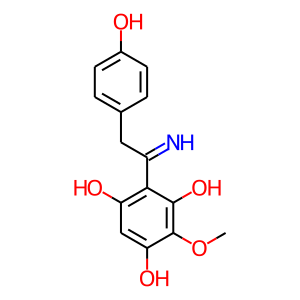

In [22]:
filename = '/share/data3/yuxiao/testt/mols/5.png'
from IPython.display import Image
Image(filename=filename)

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
string = 'B r c 1 c c c c ( N c 2 n c n c 3 c c n c c 3 c n n 2 C C N 2 C C O C C 2 ) c 1 B r'
str = string.split()
str = ''.join(str)
str
mol = Chem.MolFromSmiles(str)
Draw.MolToImage(mol, size=(300,300), kekulize=True)

## evaluate with test dataset

In [17]:
!python tools/eval.py --dump_images 0 --num_images 100000  --model log_fc/model-best.pth \
--infos_path log_fc/infos_fc-best.pkl   --language_eval 0 --force 1 \
--dump_path 1



In [19]:
import json
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
with open('vis/vis.json','r') as f:
    labels = json.load(f)
with open('data/all.json','r') as f:
    datas = json.load(f)

## caculate acc on test split

In [22]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
same = 0
right = 0
N = len(labels)
for label in tqdm(labels):
    
    img = label['image_id']
    smiles = ''.join(label['caption'].split())
    data = ''.join(datas['images'][img]['sentences'][0]['tokens'])
    if smiles == data:
        same += 1
        continue
    try:
        mol1 = Chem.MolFromSmiles(smiles)
        fps1 = FingerprintMols.FingerprintMol(mol1)
    except:
        continue
    try:
        mol2 = Chem.MolFromSmiles(data)
        fps2 = FingerprintMols.FingerprintMol(mol2)
    except:
        continue
    Similarity = DataStructs.FingerprintSimilarity(fps1,fps2)
    if Similarity == 1:
        right +=1

In [389]:
#first
print(same)
print(right)

15377
2236


In [390]:
(same+right)/N

0.25242927164846507

In [31]:
#split
print(same)
print(right)

21351
2539


In [34]:
(same+right)/N

0.3423911485653682

In [5]:
#self-criticle
print(same)
print(right)

22973
2513


In [6]:
(same+right)/N

0.36526499842348154